# Secondary Mushroom Dataset Analysis

In [1]:
# import of all the necessary libraries
import urllib
import zipfile
import os

In [2]:
# Defining the function to download and extract the file, returns the path to the extracted file

def download_and_extract_file(url, destination) -> str:
    """
    Download and extract url to destination

    :param url: url to download
    :param destination: destination path

    :return: path to extracted file
    """
    urllib.request.urlretrieve(url, destination)
    with zipfile.ZipFile(destination, "r") as zip_ref:
        zip_ref.extractall("./")
    os.remove(destination)
    name = "MushroomDataset.zip"
    with zipfile.ZipFile(name, "r") as zip_ref:
        zip_ref.extractall("./")
    os.remove(name)
    res = os.listdir("./")
    for i in res:
        if i == "MushroomDataset":
            return "./MushroomDataset/"
    return "./"

In [3]:
source = "https://archive.ics.uci.edu/static/public/848/secondary+mushroom+dataset.zip"
destination_zip = "./secondary+mushroom+dataset.zip"

datasets_path = download_and_extract_file(source, destination_zip)
print("Dataset downloaded and extracted to: " + datasets_path + "\n")

Dataset downloaded and extracted to: ./MushroomDataset/



### Transforming data from csv to DataFrame

In [4]:
df = spark.read.format("csv").load(datasets_path + "secondary_data.csv", header=True, inferSchema=True, sep=";")
df.show(5)

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     17.09|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

#### Visualization of the dataset

In [5]:
# We produce some statistics about the dataset
print("Number of rows: " + str(df.count()))
print("Number of columns: " + str(len(df.columns)))
print("Columns: " + str(df.columns))
print("Schema: ")
df.printSchema()

Number of rows: 61069
Number of columns: 21
Columns: ['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
Schema: 
root
 |-- class: string (nullable = true)
 |-- cap-diameter: double (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- does-bruise-or-bleed: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: double (nullable = true)
 |-- stem-root: string (nullable = true)
 |-- stem-surface: string (nullable = true)
 |-- stem-color: string (nullable = true)
 |-- veil-type: string (

In [6]:
# We check if there are any null values in the dataset
from pyspark.sql.functions import count, when, isnan, col
print("Number of null values in each column: ")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


Number of null values in each column: 


+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    0|           0|        0|      14120|        0|                   0|           9884|       25063|         0|          0|         0|    51538|       38124|         0|    57892|     53656|       0|     2471|            54715|      0|     0|
+-----+------------+----

In [7]:
# We remove duplicates from the dataset
print("Number of rows before removing duplicates: " + str(df.count()))
df = df.dropDuplicates()
print("Number of rows after removing duplicates: " + str(df.count()))

Number of rows before removing duplicates: 61069
Number of rows after removing duplicates: 60923


In [8]:
# We compute the statistics of the dataset
print("Statistics of the dataset: ")
df.describe().show()

Statistics of the dataset: 


23/12/29 14:19:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----+------------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|summary|class|      cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|      stem-height|        stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-------+-----+------------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|  count|60923|             60923|    60923|      46803|    60923|               60923|          51068|       35861|     60923|            60923|             60923|     9387|       228

In [9]:
# We delete the columns with a high number of null values, greater than 50% of the total number of rows
print("Number of rows before removing columns with a high number of null values: " + str(df.count()))

# We compute the number of null values in each column
null_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
null_values_dict = {}
for i in range(len(null_values)):
    if null_values[i] == 0:
        continue
    null_values_dict[null_values[i]] = df.columns[i]


Number of rows before removing columns with a high number of null values: 60923


In [10]:
# From the data above we decide to remove the columns with a high number of null values, greater than 50% of the total number of rows
null_values_to_remove = []
for i in null_values_dict:
    if i > df.count() / 2:
        null_values_to_remove.append(null_values_dict[i])

df = df.drop(*null_values_to_remove)
print("Number of rows after removing columns with a high number of null values: " + str(df.count()))
df.columns

Number of rows after removing columns with a high number of null values: 60923


['class',
 'cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

In [11]:
# For all the other columns with a low number of null values, we replace the null values with the most frequent value of the column
print("Number of rows before replacing null values: " + str(df.count()))
for i in df.columns:
    if df.filter(df[i].isNull()).count() > 0:
        most_frequent_value = df.groupBy(i).count().orderBy("count", ascending=False).collect()
        if most_frequent_value[0][0] == None:
            most_frequent_value = most_frequent_value[1][0]
        else:
            most_frequent_value = most_frequent_value[0][0]
        print("Most frequent value of column " + i + ": " + str(most_frequent_value))
        df = df.fillna(most_frequent_value, subset=[i])


Number of rows before replacing null values: 60923
Most frequent value of column cap-surface: t
Most frequent value of column gill-attachment: a
Most frequent value of column gill-spacing: c
Most frequent value of column ring-type: f


In [12]:
# We compute the number of null values in each column
null_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
null_values_dict = {}
for i in range(len(null_values)):
    if null_values[i] == 0:
        continue
    null_values_dict[null_values[i]] = df.columns[i]
null_values_dict

{}

## Transform

In [13]:
# USe the Rformula to transform the data
from pyspark.ml.feature import RFormula
formula = RFormula(formula="class ~ .")
output = formula.fit(df).transform(df)
output.show(5)
df_transformed = output

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+----------+--------+---------+-------+------+--------------------+-----+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-color|has-ring|ring-type|habitat|season|            features|label|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+----------+--------+---------+-------+------+--------------------+-----+
|    p|       13.82|        f|          h|        o|                   f|              e|           c|         w|      16.86|     17.14|         w|       t|        p|      d|     u|(80,[0,2,10,22,28...|  0.0|
|    p|       12.16|        x|          h|        e|                   f|              e|           c|         w|      17.46|     17.51|         w|       t|        

In [14]:
# We split the dataset into training and test set
train, test = df_transformed.randomSplit([0.8, 0.2], seed=42)
print("Number of rows in the training set: " + str(train.count()))
print("Number of rows in the test set: " + str(test.count()))


Number of rows in the training set: 48842
Number of rows in the test set: 12081


Gaussian Naive Bayes


In [15]:
# We define a Gaussian Naive Bayes classifier
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(modelType="gaussian", labelCol="label", featuresCol="features")

# We train the model
model = nb.fit(train)

# We make predictions on the test set
predictions_nb = model.transform(test)


Logistic Regression

In [16]:
# We define a Logistic Regression classifier
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# We train the model
model = lr.fit(train)

# We make predictions on the test set
predictions_lr = model.transform(test)

23/12/29 14:20:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Linear Discriminant Analysis / PCA

In [17]:
# We perform PCA on the dataset
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_transformed)
result = model.transform(df_transformed)

# We define a classifier using the PCA features
lr = LogisticRegression(labelCol="label", featuresCol="pcaFeatures", maxIter=10)

# We split the dataset into training and test set
train_pca, test_pca = result.randomSplit([0.8, 0.2], seed=42)

# We train the model
model = lr.fit(train_pca)

# We make predictions on the test set
predictions_lrpca = model.transform(test_pca)


23/12/29 14:20:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Random Forest Classifier

In [19]:
# We define a random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
# We train the model
model = rf.fit(train)
# We make predictions on the test set
predictions_rf = model.transform(test)

23/12/29 14:20:40 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


Definition of the evaluation function

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
# We define a function to compute the accuracy, the f1 and the f2 score of a model. We perform a binary classificatin, so we consider the class 1 as the positive class
def compute_metrics(predictions):
    """
    Compute the accuracy, the f1 and the f2 score of a model

    :param predictions: predictions of the model

    :return: accuracy, f1, f2
    """
    tp = predictions.filter(predictions.label == 1).filter(predictions.prediction == 1).count()
    tn = predictions.filter(predictions.label == 0).filter(predictions.prediction == 0).count()
    fp = predictions.filter(predictions.label == 0).filter(predictions.prediction == 1).count()
    fn = predictions.filter(predictions.label == 1).filter(predictions.prediction == 0).count()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    f2 = 5 * precision * recall / (4 * precision + recall)
    return accuracy, f1, f2
# Define a function to compute the ROC curve of a model
def compute_roc(predictions):
    """
    Compute the ROC curve of a model

    :param predictions: predictions of the model

    :return: list of tuples (false positive rate, true positive rate)
    """
    evaluator = BinaryClassificationEvaluator()
    roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    return roc

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
def compute_roc_curve(predictions):
    """
    Compute the ROC curve of a model

    :param predictions: predictions of the model

    :return: list of tuples (false positive rate, true positive rate)
    """
    roc = CurveMetrics(predictions.select("probability", "label").rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))))
    roc = roc.get_curve("roc")
    return roc
    

In [23]:
predictions = [predictions_nb, predictions_lr, predictions_lrpca, predictions_rf]
names = ["Naive Bayes", "Logistic Regression", "Logistic Regression with PCA", "Random Forest"]
evaluations = []
for i in range(len(predictions)):
    accuracy, f1, f2 = compute_metrics(predictions[i])
    roc = compute_roc(predictions[i])
    el = {"accuracy": accuracy, "f1": f1, "f2": f2, "roc": roc}
    evaluations.append(el)

# We print the results
import tabulate
headers = ["Classifier", "Accuracy", "F1", "F2", "ROC"]
table = []
for i in range(len(predictions)):
    table.append([names[i], evaluations[i]["accuracy"], evaluations[i]["f1"], evaluations[i]["f2"], evaluations[i]["roc"]])

print(tabulate.tabulate(table, headers=headers, tablefmt="github"))

| Classifier                   |   Accuracy |       F1 |       F2 |      ROC |
|------------------------------|------------|----------|----------|----------|
| Naive Bayes                  |   0.625114 | 0.693344 | 0.829687 | 0.691132 |
| Logistic Regression          |   0.77535  | 0.752913 | 0.763761 | 0.849207 |
| Logistic Regression with PCA |   0.592997 | 0.416241 | 0.357624 | 0.63085  |
| Random Forest                |   0.837845 | 0.805172 | 0.774263 | 0.917156 |


/opt/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


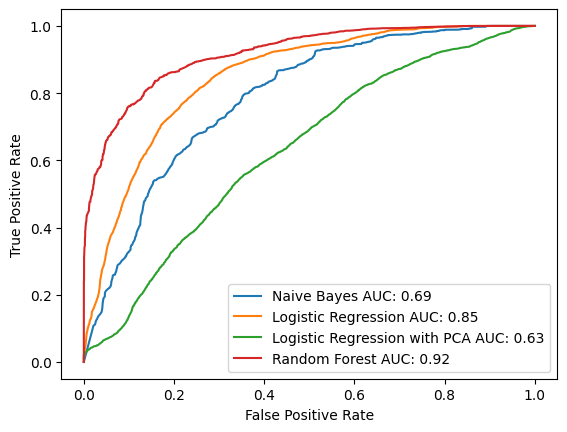

In [24]:
# We plot the ROC curve of the models
import matplotlib.pyplot as plt
roc_nb = compute_roc_curve(predictions_nb)
roc_lr = compute_roc_curve(predictions_lr)
roc_lrpca = compute_roc_curve(predictions_lrpca)
roc_rf = compute_roc_curve(predictions_rf)

plt.plot([x[0] for x in roc_nb], [x[1] for x in roc_nb], label=f"Naive Bayes AUC: {compute_roc(predictions_nb):.2f}")
plt.plot([x[0] for x in roc_lr], [x[1] for x in roc_lr], label=f"Logistic Regression AUC: {compute_roc(predictions_lr):.2f}")
plt.plot([x[0] for x in roc_lrpca], [x[1] for x in roc_lrpca], label=f"Logistic Regression with PCA AUC: {compute_roc(predictions_lrpca):.2f}")
plt.plot([x[0] for x in roc_rf], [x[1] for x in roc_rf], label=f"Random Forest AUC: {compute_roc(predictions_rf):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

Decision Tree

In [26]:
# We now fit a Decision Tree model on the training set
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(train)
predictions_dt = model.transform(test)

Gradient-boosted tree classifier

In [27]:
# We fit a gradient boosted tree model on the training set
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50)
model = gbt.fit(train)
predictions_gbt = model.transform(test)

MultiLayer Perceptron Classifier

In [40]:
# We fit a multilayer perceptron model on the training set
from pyspark.ml.classification import MultilayerPerceptronClassifier
layers = [80, 5, 4, 2]
mp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, featuresCol="features", labelCol="label")
model = mp.fit(train)
predictions_mp = model.transform(test)

23/12/29 14:51:12 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed


Linear support vector Machine

In [29]:
# We fit a linear support vector machine model on the training set
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=50, regParam=0.1)
model = lsvc.fit(train)
predictions_lsvc = model.transform(test)

One vs Rest

In [30]:
# We fit a one-vs-rest support vector machine model on the training set
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=50, regParam=0.1)
ovr = OneVsRest(classifier=lsvc)
model = ovr.fit(train)
predictions_ovr = model.transform(test)

Factorization machines classification

In [36]:
# We fit a factorization machines model on the training set
from pyspark.ml.classification import FMClassifier
fm = FMClassifier(labelCol="label", featuresCol="features")
model = fm.fit(train)
predictions_fm = model.transform(test)

Evaluation of all models

In [41]:
predictions = [predictions_dt, predictions_gbt, predictions_mp, predictions_lsvc, predictions_ovr, predictions_fm]
names = ["Decision Tree", "Gradient Boosted Tree", "Multilayer Perceptron", "Linear SVM", "One-vs-Rest SVM", "Factorization Machines"]
evaluations = []
for i in range(len(predictions)):
    accuracy, f1, f2 = compute_metrics(predictions[i])
    roc = compute_roc(predictions[i])
    el = {"accuracy": accuracy, "f1": f1, "f2": f2, "roc": roc}
    evaluations.append(el)

# We print the results
import tabulate
headers = ["Classifier", "Accuracy", "F1", "F2", "ROC"]
table = []
for i in range(len(predictions)):
    table.append([names[i], evaluations[i]["accuracy"], evaluations[i]["f1"], evaluations[i]["f2"], evaluations[i]["roc"]])

print(tabulate.tabulate(table, headers=headers, tablefmt="github"))

| Classifier             |   Accuracy |       F1 |       F2 |      ROC |
|------------------------|------------|----------|----------|----------|
| Decision Tree          |   0.70764  | 0.595047 | 0.523017 | 0.669057 |
| Gradient Boosted Tree  |   0.9827   | 0.980476 | 0.979433 | 0.997739 |
| Multilayer Perceptron  |   0.747869 | 0.758024 | 0.831938 | 0.81482  |
| Linear SVM             |   0.781641 | 0.762428 | 0.778411 | 0.838115 |
| One-vs-Rest SVM        |   0.781641 | 0.762428 | 0.778411 | 0.838111 |
| Factorization Machines |   0.961841 | 0.956872 | 0.954995 | 0.993068 |
